# Time series forecasting with DeepAR
DeepAR is a supervised learning algorithm for forecasting scalar time series. 


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
bucket = 'sagemaker-testtimeseries'
prefix = 'sagemaker/test-moredat'
 
# Define IAM role
import sagemaker

import sagemaker.predictor
from sagemaker.predictor import csv_serializer, json_deserializer
import boto3
import  s3fs
import re
from sagemaker import get_execution_role
import json
import math
from os import path
import sagemaker.amazon.common as smac

role = get_execution_role()


Now we'll import the Python libraries we'll need.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import time
import json
import glob

In [3]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [4]:

containers  = {
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]


---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [5]:
#!wget http://gwa.ewi.tudelft.nl/fileadmin/pds/trace-archives/grid-workloads-archive/datasets/gwa-t-12/rnd.zip

In [6]:
#import zipfile
#with zipfile.ZipFile("rnd.zip","r") as zip_ref:
#    zip_ref.extractall("targetdir")

And take a look at it.

# Read in Data

### 111 ts files max (across 3 months), any more and notebook crashes (on my desktop)


In [7]:
files = glob.glob(os.path.join('targetdir/rnd/2013-7', "1*.csv"))
files_first200 = files[:120]
dfs = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files]
df = pd.concat(dfs, ignore_index=True)

files2 = glob.glob(os.path.join('targetdir/rnd/2013-8', "1*.csv"))
files2_first200 = files2[:120]
dfs2 = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files2]
df2 = pd.concat(dfs2, ignore_index=True)

files3 = glob.glob(os.path.join('targetdir/rnd/2013-9', "1*.csv"))
files3_first200 = files3[:120]
dfs3 = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files3]
df3 = pd.concat(dfs3, ignore_index=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifyin

## Data Wrangling

In [8]:
newdat = df.append(df2)
newerdat = newdat.append(df3)
concatenated_df = newerdat

In [9]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1372629804,1,2599.999398,41.599990,1.600000,2097152.0,260044.800000,0.400000,7.8,1.666667,7.400000,13
1,1372630104,1,2599.999398,36.399992,1.400000,2097152.0,281016.800000,0.133333,10.0,1.000000,2.000000,13
2,1372630404,1,2599.999398,25.999994,1.000000,2097152.0,209712.000000,0.200000,7.4,1.000000,1.466667,13
3,1372630704,1,2599.999398,31.199993,1.200000,2097152.0,209712.000000,0.066667,6.8,1.000000,1.400000,13
4,1372631004,1,2599.999398,29.466660,1.133333,2097152.0,254453.066667,0.133333,7.0,1.000000,1.466667,13


In [10]:
concatenated_df.tail()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
926201,1380491363,4,11703.997296,150.201299,1.283333,16703488.0,167772.0,0.0,0.066667,0.0,0.0,106
926202,1380491630,4,11703.997296,197.017288,1.683333,16703488.0,100663.2,0.0,1.666667,0.0,0.0,106
926203,1380491663,4,11703.997296,197.017288,1.683333,16703488.0,100663.2,0.0,1.666667,0.0,0.0,106
926204,1380491930,4,11703.997296,146.299966,1.250000,16703488.0,111848.0,0.0,0.000000,0.0,0.0,106
926205,1380491963,4,11703.997296,146.299966,1.250000,16703488.0,111848.0,0.0,0.000000,0.0,0.0,106


In [11]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
concatenated_df.describe()
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek


concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
# Feature engineering with the date
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]

concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

In [12]:
concatenated_df["start"] = concatenated_df.index
concatenated_df['target'] = concatenated_df['CPU usage [MHZ]']

In [13]:

result = pd.concat([concatenated_df['VM'],concatenated_df['start'], concatenated_df['target']], axis=1)
result = result.reset_index()
#result.set_index('start',inplace=True)

result.set_index(['start', 'VM'],inplace=True)
result.drop('Timestamp', axis=1, inplace=True)


In [14]:
df = concatenated_df.groupby('VM').resample('1min', how={'target':np.mean})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1502: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


In [15]:
df.reset_index(level=0, inplace=True)

In [16]:
#df['Timestamp'] = df['Timestamp'].dt.strftime('%m/%d/%Y %H:%M:%S')

In [17]:
df = df.fillna(method='ffill')

In [18]:
freq = "1min"
context_length = 50
prediction_length = 50

In [19]:
dftrain = df[:-(prediction_length)]

## Format data into json 

In [20]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [21]:
time_series_test=[]
vm_index_range = df['VM'].unique()
for i in vm_index_range:
    newseries = df[df['VM'] == i]['target']
    del newseries.index.name
    newseries.index = pd.to_datetime(newseries.index)
    time_series_test.append(newseries)
    #time_series_test = time_series_test.fillna(0)


In [22]:
time_series_training=[]
vm_index_range = df['VM'].unique()
for i in vm_index_range:
    newseries = df[df['VM'] == i]['target']
    del newseries.index.name
    newseries.index = pd.to_datetime(newseries.index)
    time_series_training.append(newseries[:-prediction_length])
    #time_series_training = time_series_training.fillna(0)
    


## Push the json files to S3 bucket

In [23]:
s3filesystem = s3fs.S3FileSystem()

In [24]:
encoding = "utf-8"

with s3filesystem.open(s3_data_path + "/test/test_data.json", 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding)) 

In [25]:
with s3filesystem.open(s3_data_path + "/train/train_data.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding)) 

In [26]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='test-demo-deepar',
    output_path="s3://" + s3_output_path
)

## Set hyperparameters

In [27]:
# sagemaker automatically adds lags, so context length can be shorter than seasons

In [28]:
hyperparameters  = {
    "time_freq": freq,
    "context_length": context_length,
    "prediction_length": prediction_length,
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "student-t",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [29]:
estimator.set_hyperparameters(**hyperparameters)

## Train model

In [30]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: test-demo-deepar-2018-06-22-14-43-26-968


....................
Arguments: train
[06/22/2018 14:46:39 INFO 140433059022656] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.10', u'cardinality': u'', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/22/2018 14:46:39 INFO 140433059022656] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'50', u'epochs': u'20', u'time_freq': u'1min', u'context_length': u'50', u'num_layers': u'2', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u'

[06/22/2018 14:46:57 INFO 140433059022656] Epoch[3] Batch[0] avg_epoch_loss=4.417615
[06/22/2018 14:46:59 INFO 140433059022656] Epoch[3] Batch[5] avg_epoch_loss=4.360275
[06/22/2018 14:46:59 INFO 140433059022656] Epoch[3] Batch [5]#011Speed: 65.58 samples/sec#011loss=4.360275
[06/22/2018 14:47:01 INFO 140433059022656] processed a total of 310 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4637.401103973389, "sum": 4637.401103973389, "min": 4637.401103973389}}, "EndTime": 1529678821.449688, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529678816.797193}

[06/22/2018 14:47:01 INFO 140433059022656] #throughput_metric: host=algo-1, train throughput=66.8461577376 records/second
[06/22/2018 14:47:01 INFO 140433059022656] #progress_metric: host=algo-1, completed 20 % of epochs
[06/22/2018 14:47:01 INFO 140433059022656] best epoch loss so far
[06/22/2018 14:47:01 INFO 140433059022656] Saved checkpoint to "/opt/ml/model/st

[06/22/2018 14:47:35 INFO 140433059022656] Epoch[11] Batch[0] avg_epoch_loss=3.883921
[06/22/2018 14:47:37 INFO 140433059022656] Epoch[11] Batch[5] avg_epoch_loss=4.112011
[06/22/2018 14:47:37 INFO 140433059022656] Epoch[11] Batch [5]#011Speed: 66.29 samples/sec#011loss=4.112011
[06/22/2018 14:47:39 INFO 140433059022656] processed a total of 291 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4579.229831695557, "sum": 4579.229831695557, "min": 4579.229831695557}}, "EndTime": 1529678859.135341, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529678854.541701}

[06/22/2018 14:47:39 INFO 140433059022656] #throughput_metric: host=algo-1, train throughput=63.5462589476 records/second
[06/22/2018 14:47:39 INFO 140433059022656] #progress_metric: host=algo-1, completed 60 % of epochs
[06/22/2018 14:47:39 INFO 140433059022656] best epoch loss so far
[06/22/2018 14:47:39 INFO 140433059022656] Saved checkpoint to "/opt/ml/model

[06/22/2018 14:48:07 INFO 140433059022656] Epoch[17] Batch[10] avg_epoch_loss=3.777749
[06/22/2018 14:48:07 INFO 140433059022656] Epoch[17] Batch [10]#011Speed: 78.08 samples/sec#011loss=3.846410
[06/22/2018 14:48:07 INFO 140433059022656] processed a total of 321 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4671.702861785889, "sum": 4671.702861785889, "min": 4671.702861785889}}, "EndTime": 1529678887.467989, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529678882.781854}

[06/22/2018 14:48:07 INFO 140433059022656] #throughput_metric: host=algo-1, train throughput=68.7099873636 records/second
[06/22/2018 14:48:07 INFO 140433059022656] #progress_metric: host=algo-1, completed 90 % of epochs
[06/22/2018 14:48:07 INFO 140433059022656] best epoch loss so far
[06/22/2018 14:48:07 INFO 140433059022656] Saved checkpoint to "/opt/ml/model/state_02703d84-e6c1-4d84-9acc-1c2fc40afccd-0000.params"
#metrics {"Metrics": {"stat

===== Job Complete =====
Billable seconds: 225


## Create endpoint and predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

Note: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [31]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: test-demo-deepar-2018-06-22-14-43-26-968
INFO:sagemaker:Creating endpoint-config with name test-demo-deepar-2018-06-22-14-43-26-968
INFO:sagemaker:Creating endpoint with name test-demo-deepar-2018-06-22-14-43-26-968


--------------------------------------------------------------------------!

In [32]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [33]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Visualize Model Predictions

In [34]:
new_time_series_training = []
for ts in time_series_training:
    new_time_series_training.append(ts.asfreq('T'))

In [35]:
new_time_series_test = []
for ts in time_series_test:
    new_time_series_test.append(ts.asfreq('T'))



In [40]:
# 2 max for memory (on my desktop)
list_of_df  = predictor.predict(new_time_series_training[1:2]) # predicted forecast
actual_data = new_time_series_test[1:2] # full data set

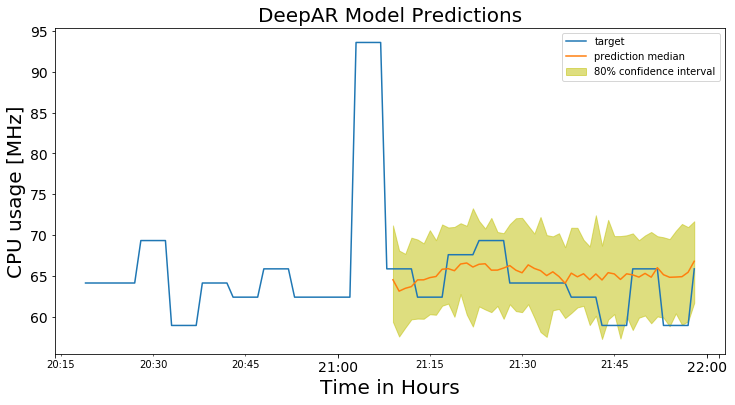

In [45]:
for k in range(len(list_of_df)): 
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median') # set requests for capacity allocation 
    plt.title("DeepAR Model Predictions", fontsize = 20)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    plt.xlabel("Time in Hours", fontsize = 20)
    plt.yticks(fontsize=14);
    #plt.axhline(y=2599.999299, color='g', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend()
    plt.show()

# Calculate CPU usage saved
Compare p90 to what was actually provisioned

In [99]:
'''vm101_p90 = pd.DataFrame(p90)
vm101_p90['VM'] = '101'
vm101_p90.to_csv('vm101_p90.csv', sep = ',')


vm102_p90 = pd.DataFrame(p90)
vm102_p90['VM'] = '102'
vm102_p90.to_csv('vm102_p90.csv', sep = ',')

vm103_p90 = pd.DataFrame(p90)
vm103_p90['VM'] = '103'
vm103_p90.to_csv('vm103_p90.csv', sep = ',')


vm104_p90 = pd.DataFrame(p90)
vm104_p90['VM'] = '104'
vm104_p90.to_csv('vm104_p90.csv', sep = ',')

vm105_p90 = pd.DataFrame(p90)
vm105_p90['VM'] = '105'
vm105_p90.to_csv('vm105_p90.csv', sep = ',')

vm106_p90 = pd.DataFrame(p90)
vm106_p90['VM'] = '106'
vm106_p90.to_csv('vm106_p90.csv', sep = ',')

vm107_p90 = pd.DataFrame(p90)
vm107_p90['VM'] = '107'
vm107_p90.to_csv('vm107_p90.csv', sep = ',')

vm11_p90 = pd.DataFrame(p90)
vm11_p90['VM'] = '11'
vm11_p90.to_csv('vm11_p90.csv', sep = ',')

vm10_p90 = pd.DataFrame(p90)
vm10_p90['VM'] = '10'
vm10_p90.to_csv('vm10_p90.csv', sep = ',')

vm1_p90 = pd.DataFrame(p90)
vm1_p90['VM'] = '1'
vm1_p90.to_csv('vm1_p90.csv', sep = ',')

vm111_p90 = pd.DataFrame(p90)
vm111_p90['VM'] = '111'
vm111_p90.to_csv('vm111_p90.csv', sep = ',')

'''

two paths:
1. iterating and improving model fit
    - try to get it to full data set- as big as possible 
    - get test metric !!! - if large enough use RMSE
    - use model to make predictions (hold out data or ?)
    
    
2. look at p90- upper bound in graph = max capacity set in real time, cost calc between this and actual capacity that was provisioned, 

3. extra: try to get in hyperparameter tuning 

4. put final cleaned up notebook

5. accessing data and documentation MAKE CLEAR notes on 

Best Model before Tuning

[06/21/2018 04:01:21 INFO 140419976746816] #quality_metric: host=algo-1, test RMSE <loss>=7.21890483211
#metrics {"Metrics": {"totaltime": {"count": 1, "max": 121637.42303848267, "sum": 121637.42303848267, "min": 121637.42303848267}, "setuptime": {"count": 1, "max": 8.651018142700195, "sum": 8.651018142700195, "min": 8.651018142700195}}, "EndTime": 1529553682.117442, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529553681.585015}
    
    
[06/21/2018 22:32:27 INFO 140337100830528] #quality_metric: host=algo-1, test RMSE <loss>=9.11701511459
#metrics {"Metrics": {"totaltime": {"count": 1, "max": 113834.45906639099, "sum": 113834.45906639099, "min": 113834.45906639099}, "setuptime": {"count": 1, "max": 8.47005844116211, "sum": 8.47005844116211, "min": 8.47005844116211}}, "EndTime": 1529620347.585514, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1529620347.161478}


## Created hyperparameter tuning job on the GUI (which now fails),  attempting to do with code below. 

So far, no examples of full hyperparameter tuning code available, that I have found at least.

In [176]:
s3_input_train = 's3://{}/{}/data/train'.format(bucket, prefix)
s3_input_test= 's3://{}/{}/data/test'.format(bucket, prefix)
training_image = containers[region]

In [182]:
s3_input_train

's3://sagemaker-testtimeseries/sagemaker/test-moredat/data/train'

In [177]:
HyperParameterTuningJobConfig={
        'Strategy': 'Bayesian',
        'HyperParameterTuningJobObjective': {
            'Type': 'Minimize',
            'MetricName': 'test:RMSE'
        },
        'ResourceLimits': {
            'MaxNumberOfTrainingJobs': 50,
            'MaxParallelTrainingJobs': 3
        },
        'ParameterRanges': {
            'IntegerParameterRanges': [
                {
                    'Name': 'mini_batch_size',
                    'MinValue': '32',
                    'MaxValue': '50'
                },
                {
                    'Name': 'epochs',
                    'MinValue': '32',
                    'MaxValue': '50'
                },
                {
                    'Name': 'context_length',
                    'MinValue': '20',
                    'MaxValue': '50'
                },            
                {
                    'Name': 'num_cells',
                    'MinValue': '30',
                    'MaxValue': '70'
                },            
                {
                    'Name': 'num_layers',
                    'MinValue': '1',
                    'MaxValue': '5'
                },                  
            
            ],
            'ContinuousParameterRanges': [
                {
                    'Name': 'dropout_rate',
                    'MinValue': '0.00',
                    'MaxValue': '0.2'
                },
                {
                    'Name': 'learning_rate',
                    'MinValue': '0.0001',
                    'MaxValue': '0.01'
                }
            
            ]
            
        }
    }
TrainingJobDefinition={
        'AlgorithmSpecification': {
            'TrainingImage': training_image,
            'TrainingInputMode': 'File',
            
        },
        'RoleArn': role,
        'StaticHyperParameters': [{
            "prediction_length": '50',
            "time_freq": 'min',
            "test_quantiles": '[0.5, 0.9]'
#            "_tuning_objective_metric": 'test:RMSE'
        }],
        'InputDataConfig': [
            {
                'ChannelName': 'train',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': s3_input_train,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'json',
                'CompressionType': 'None',
                'RecordWrapperType': 'None'
            ,
                
            'ChannelName': 'test',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': s3_input_test,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'json',
                'CompressionType': 'None',
                'RecordWrapperType': 'None'

            }
        ],

        'OutputDataConfig': {
            "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
        },
        'ResourceConfig': {
            'InstanceType': 'ml.m4.xlarge',
            'InstanceCount': 1,
            'VolumeSizeInGB': 1,
        },
    'StoppingCondition': {
            'MaxRuntimeInSeconds': 86400
        }
        
}

In [179]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = 'tuning11',
                                            HyperParameterTuningJobConfig = HyperParameterTuningJobConfig,
                                            TrainingJobDefinition = TrainingJobDefinition1)


{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-west-2:945416147148:hyper-parameter-tuning-job/tuning11',
 'ResponseMetadata': {'RequestId': 'c94d49f8-6a3b-48eb-a612-7df60616ab1d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 21 Jun 2018 19:48:04 GMT',
   'x-amzn-requestid': 'c94d49f8-6a3b-48eb-a612-7df60616ab1d',
   'content-length': '109',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Query a trained model by using the model's endpoint. The endpoint takes the following JSON request format.

# making predictions

In [ ]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")




In [ ]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(year, data):
    year_temps = data[str(year)]
    s = {"start": "{}-01-01 00:00:00".format(year), "target": year_temps}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)


In [61]:

{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0], "cat": 0},
  { "start": "2012-01-30", "target": [1.0], "cat": 2 },
  { "start": "1999-01-30", "target": [2.0, 1.0], "cat": 1 }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["mean", "quantiles", "samples"],
  "quantiles": ["0.5", "0.9"]
 }
}

{'instances': [{'start': '2009-11-01 00:00:00',
   'target': [4.0, 10.0, 50.0, 100.0, 113.0],
   'cat': 0},
  {'start': '2012-01-30', 'target': [1.0], 'cat': 2},
  {'start': '1999-01-30', 'target': [2.0, 1.0], 'cat': 1}],
 'configuration': {'num_samples': 50,
  'output_types': ['mean', 'quantiles', 'samples'],
  'quantiles': ['0.5', '0.9']}}

In [46]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: test-demo-deepar-2018-06-22-14-43-26-968
